# Random Forest Classifier

In [86]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.model_selection import GridSearchCV
import os

from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
import seaborn as sns


os.chdir("../data")

In [56]:
df = pd.read_excel("dataproject2024.xlsx")

In [57]:
X = df.drop(["Default (y)", "Pred_default (y_hat)", "ID", "PD"], axis=1)
y = df["Default (y)"]

In [58]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [59]:
# 1. Define the parameter grid for Random Forest
param_grid_rf = {
    "n_estimators": [100, 200, 300],  # Number of trees in the forest
    "max_depth": [None, 10, 20, 30],  # Maximum depth of the tree
    "min_samples_split": [
        2,
        5,
        10,
    ],  # Minimum number of samples required to split a node
    "min_samples_leaf": [1, 2, 4],  # Minimum number of samples required at a leaf node
    "bootstrap": [True, False],  # Whether bootstrap samples are used
}

In [60]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [61]:
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

In [62]:
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

In [63]:
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8093
AUC-ROC: 0.7568

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.95      0.89      1788
           1       0.54      0.23      0.32       441

    accuracy                           0.81      2229
   macro avg       0.69      0.59      0.61      2229
weighted avg       0.78      0.81      0.78      2229



In [64]:
feature_importances = rf_model.feature_importances_
importance_df = pd.DataFrame(
    {"Feature": X.columns, "Importance": feature_importances}
).sort_values(by="Importance", ascending=False)

print("\nFeature Importances:\n", importance_df)


Feature Importances:
             Feature  Importance
3    Funding amount    0.197999
6   Monthly payment    0.187286
2         Car price    0.185477
1               Age    0.156386
0        Job tenure    0.113388
5     Loan duration    0.073641
9         Homeowner    0.025741
8           Married    0.020812
10            Group    0.018520
7      Credit event    0.012922
4      Down payment    0.007829


In [65]:
result_df = X_test.copy()
result_df["Predicted_PD"] = y_pred_proba
result_df["True_Label"] = y_test.values

print(result_df.head())

result_df.to_csv("predictions_output_random_forest.csv", index=False)

      Job tenure  Age  Car price  Funding amount  Down payment  Loan duration  \
625            2   22       8900            8900             0             60   
2796           0   55      10400            9400             0             72   
101            1   40      15990           14990             0             60   
4767           5   43      19999           23233             0             72   
2018           1   26      11800            4298             1             24   

      Monthly payment  Credit event  Married  Homeowner  Group  Predicted_PD  \
625          0.084828             0        0          0      0          0.32   
2796         0.083889             0        0          0      0          0.19   
101          0.127142             0        1          0      0          0.25   
4767         0.153289             0        0          0      0          0.26   
2018         0.115528             0        0          0      0          0.18   

      True_Label  
625          

# Gradient Boosting Classifier

In [66]:
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [67]:
y_pred = gb_model.predict(X_test)
y_pred_proba = gb_model.predict_proba(X_test)[:, 1]

In [68]:
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

In [69]:
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

Accuracy: 0.8170
AUC-ROC: 0.7684


In [70]:
result_df = X_test.copy()
result_df["Predicted_PD"] = y_pred_proba
result_df["True_Label"] = y_test.values

print(result_df.head())

result_df.to_csv("predictions_output_gradient_boosting.csv", index=False)

      Job tenure  Age  Car price  Funding amount  Down payment  Loan duration  \
625            2   22       8900            8900             0             60   
2796           0   55      10400            9400             0             72   
101            1   40      15990           14990             0             60   
4767           5   43      19999           23233             0             72   
2018           1   26      11800            4298             1             24   

      Monthly payment  Credit event  Married  Homeowner  Group  Predicted_PD  \
625          0.084828             0        0          0      0      0.244713   
2796         0.083889             0        0          0      0      0.327168   
101          0.127142             0        1          0      0      0.189396   
4767         0.153289             0        0          0      0      0.391459   
2018         0.115528             0        0          0      0      0.119370   

      True_Label  
625          

Next steps:
- Hyperparameter tuning using GridSearchCV to optimize your Random Forest or Gradient Boosting model.
- Using SHAP (SHapley Additive exPlanations) to interpret your black-box model's predictions.

# Partial Dependence Plots

In [184]:
def plot_partial_dependence(
    model, 
    X, 
    continuous_threshold: int = 10, 
    kind: str = "average", 
    n_cols: int = 3, 
    figsize_factor: float = 5, 
    centered: bool = None, 
    method: str = "brute", 
    subsample: int = 1000,
    line_kw = None, 
    ice_lines_kw = None, 
    pd_line_kw = None, 
    contour_kw = None
):
    if kind not in ["average", "individual", "both"]:
        raise ValueError(f"Invalid value for 'kind': {kind}. Choose either 'average', 'individual', or 'both'.")

    continuous_features = [col for col in X.columns if X[col].nunique() > continuous_threshold]
    categorical_features = [col for col in X.columns if col not in continuous_features]
    features_to_plot = X.columns

    n_features = len(features_to_plot)
    n_rows = (n_features // n_cols) + (n_features % n_cols > 0)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * figsize_factor), constrained_layout=True)
    axs = axs.flatten()

    for j in range(n_features, n_rows * n_cols):
        fig.delaxes(axs[j])

    axs = axs[:n_features]

    if centered is None:
        centered = (kind in ["individual", "both"])

    categorical_setting = None if kind in ["individual", "both"] else categorical_features
    title = f"{'ICE' if kind in ['individual', 'both'] else 'Partial Dependence'} Plots for All Features"


    display = PartialDependenceDisplay.from_estimator(
        model, X, features_to_plot, ax=axs, categorical_features=categorical_setting, kind=kind, 
        centered=centered, method=method, subsample=subsample,
        line_kw=line_kw or {'linestyle': '--', 'color': 'gray'},
        ice_lines_kw=ice_lines_kw or {'alpha': 0.2, 'color': 'blue'},
        pd_line_kw=pd_line_kw or {'linewidth': 3, 'color': 'red'},
        contour_kw=contour_kw or {'cmap': 'plasma', 'alpha': 0.6}
    )

    for i, feature in enumerate(features_to_plot):
        if feature in categorical_features:
            unique_vals = np.sort(X[feature].unique())
            axs[i].set_xticks(unique_vals)

        axs[i].set_title(f"Plot for {feature}")
        axs[i].set_ylabel("Predicted PD")

    plt.suptitle(title, fontsize=20)
    plt.show()


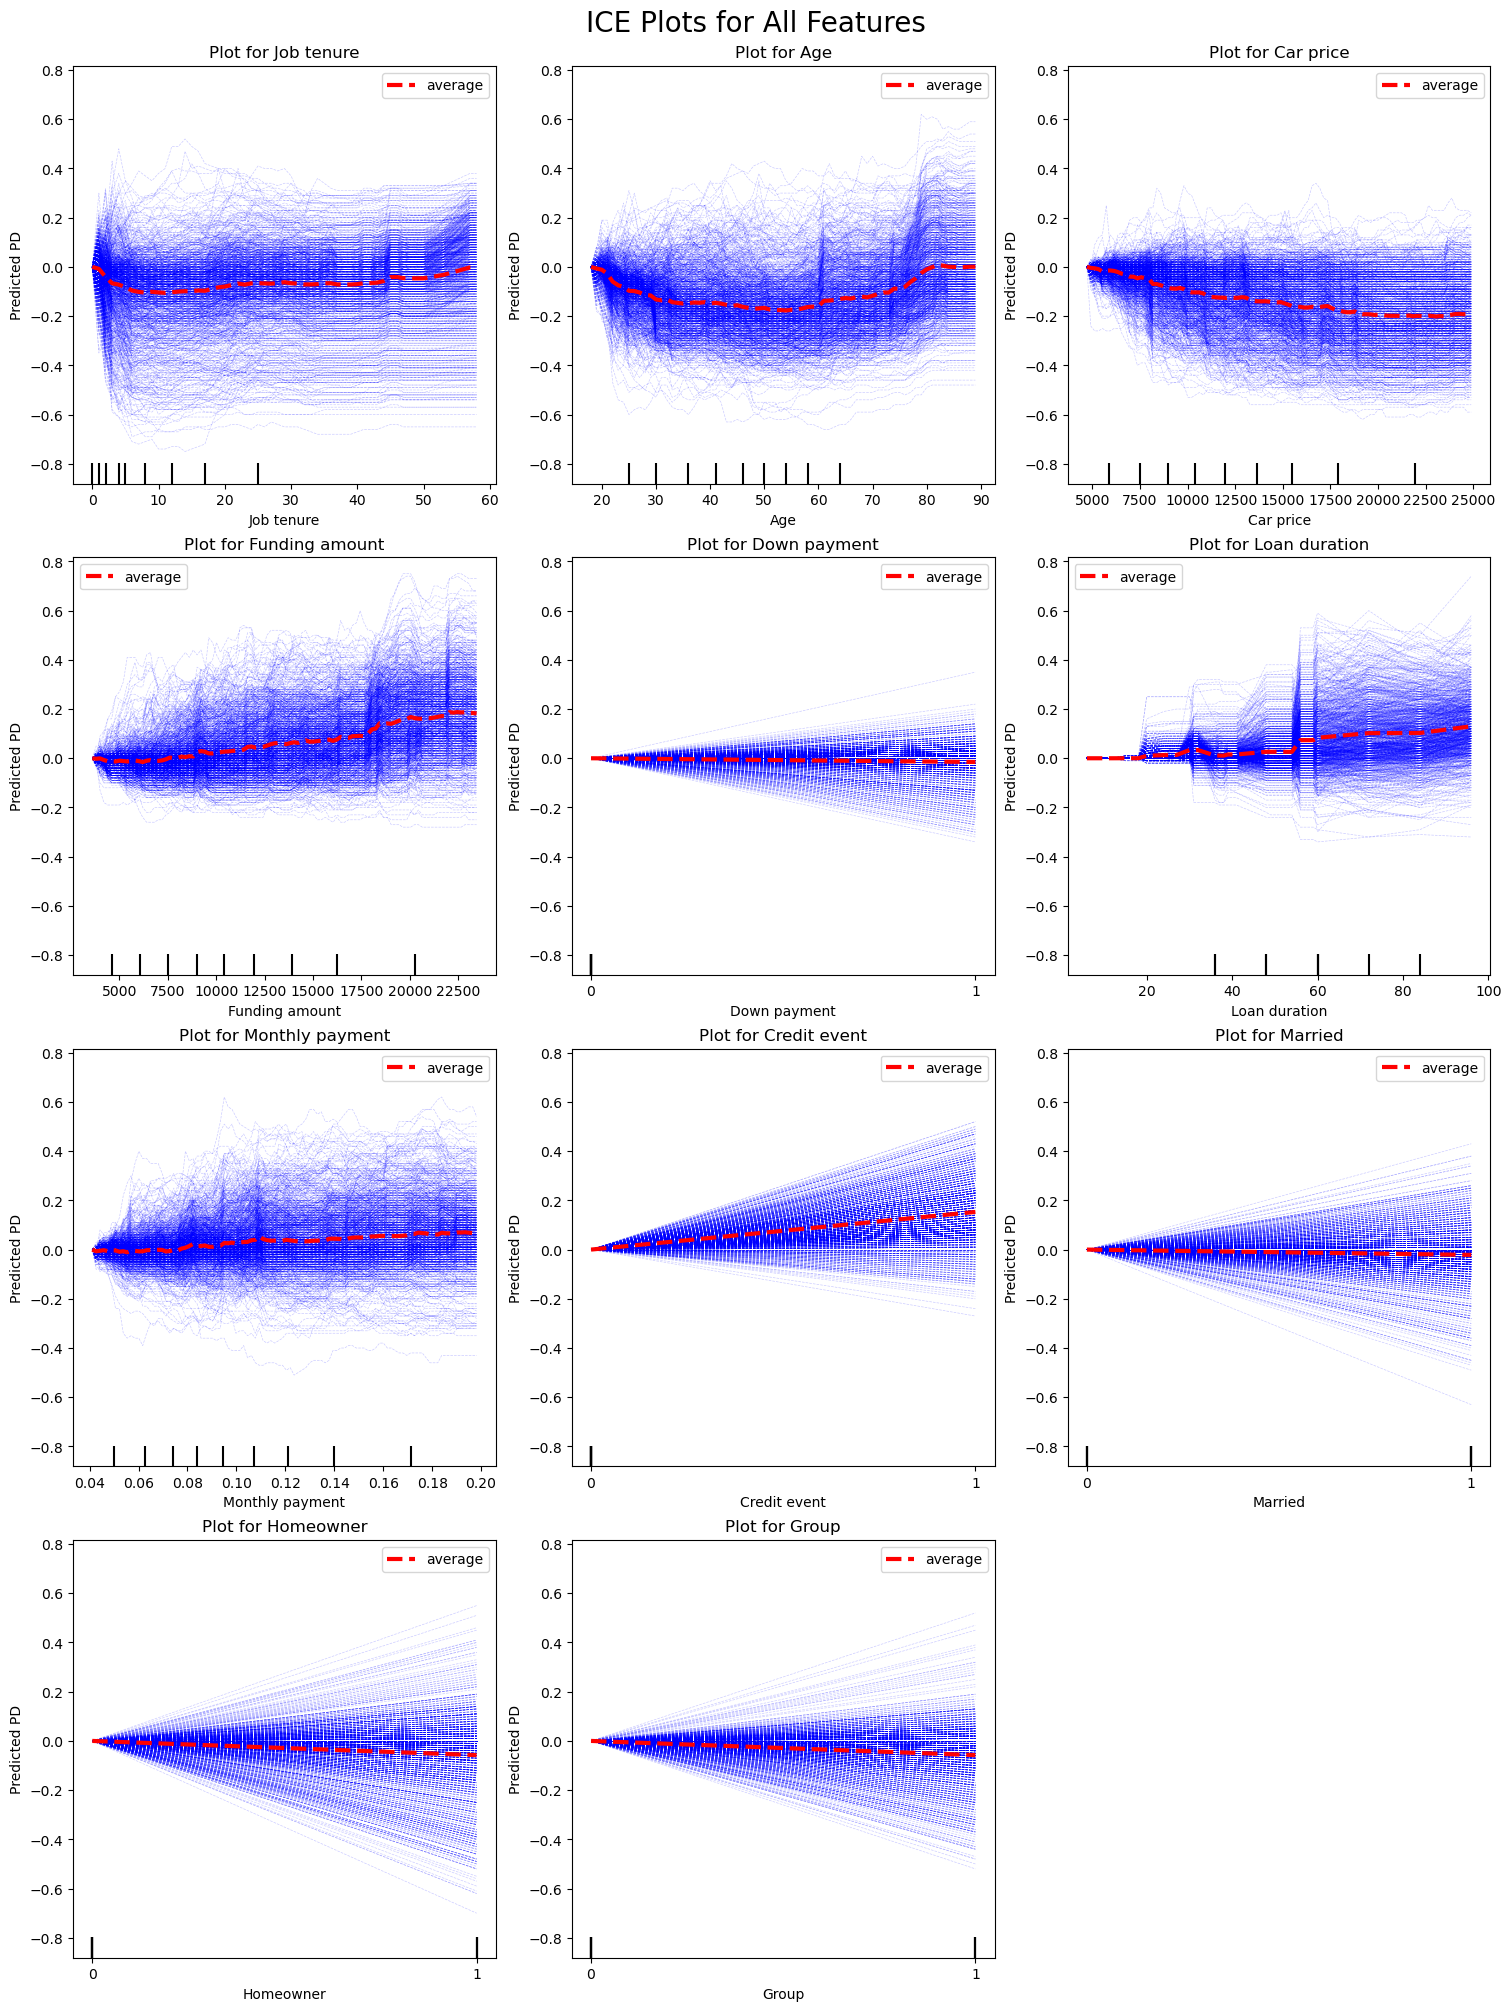

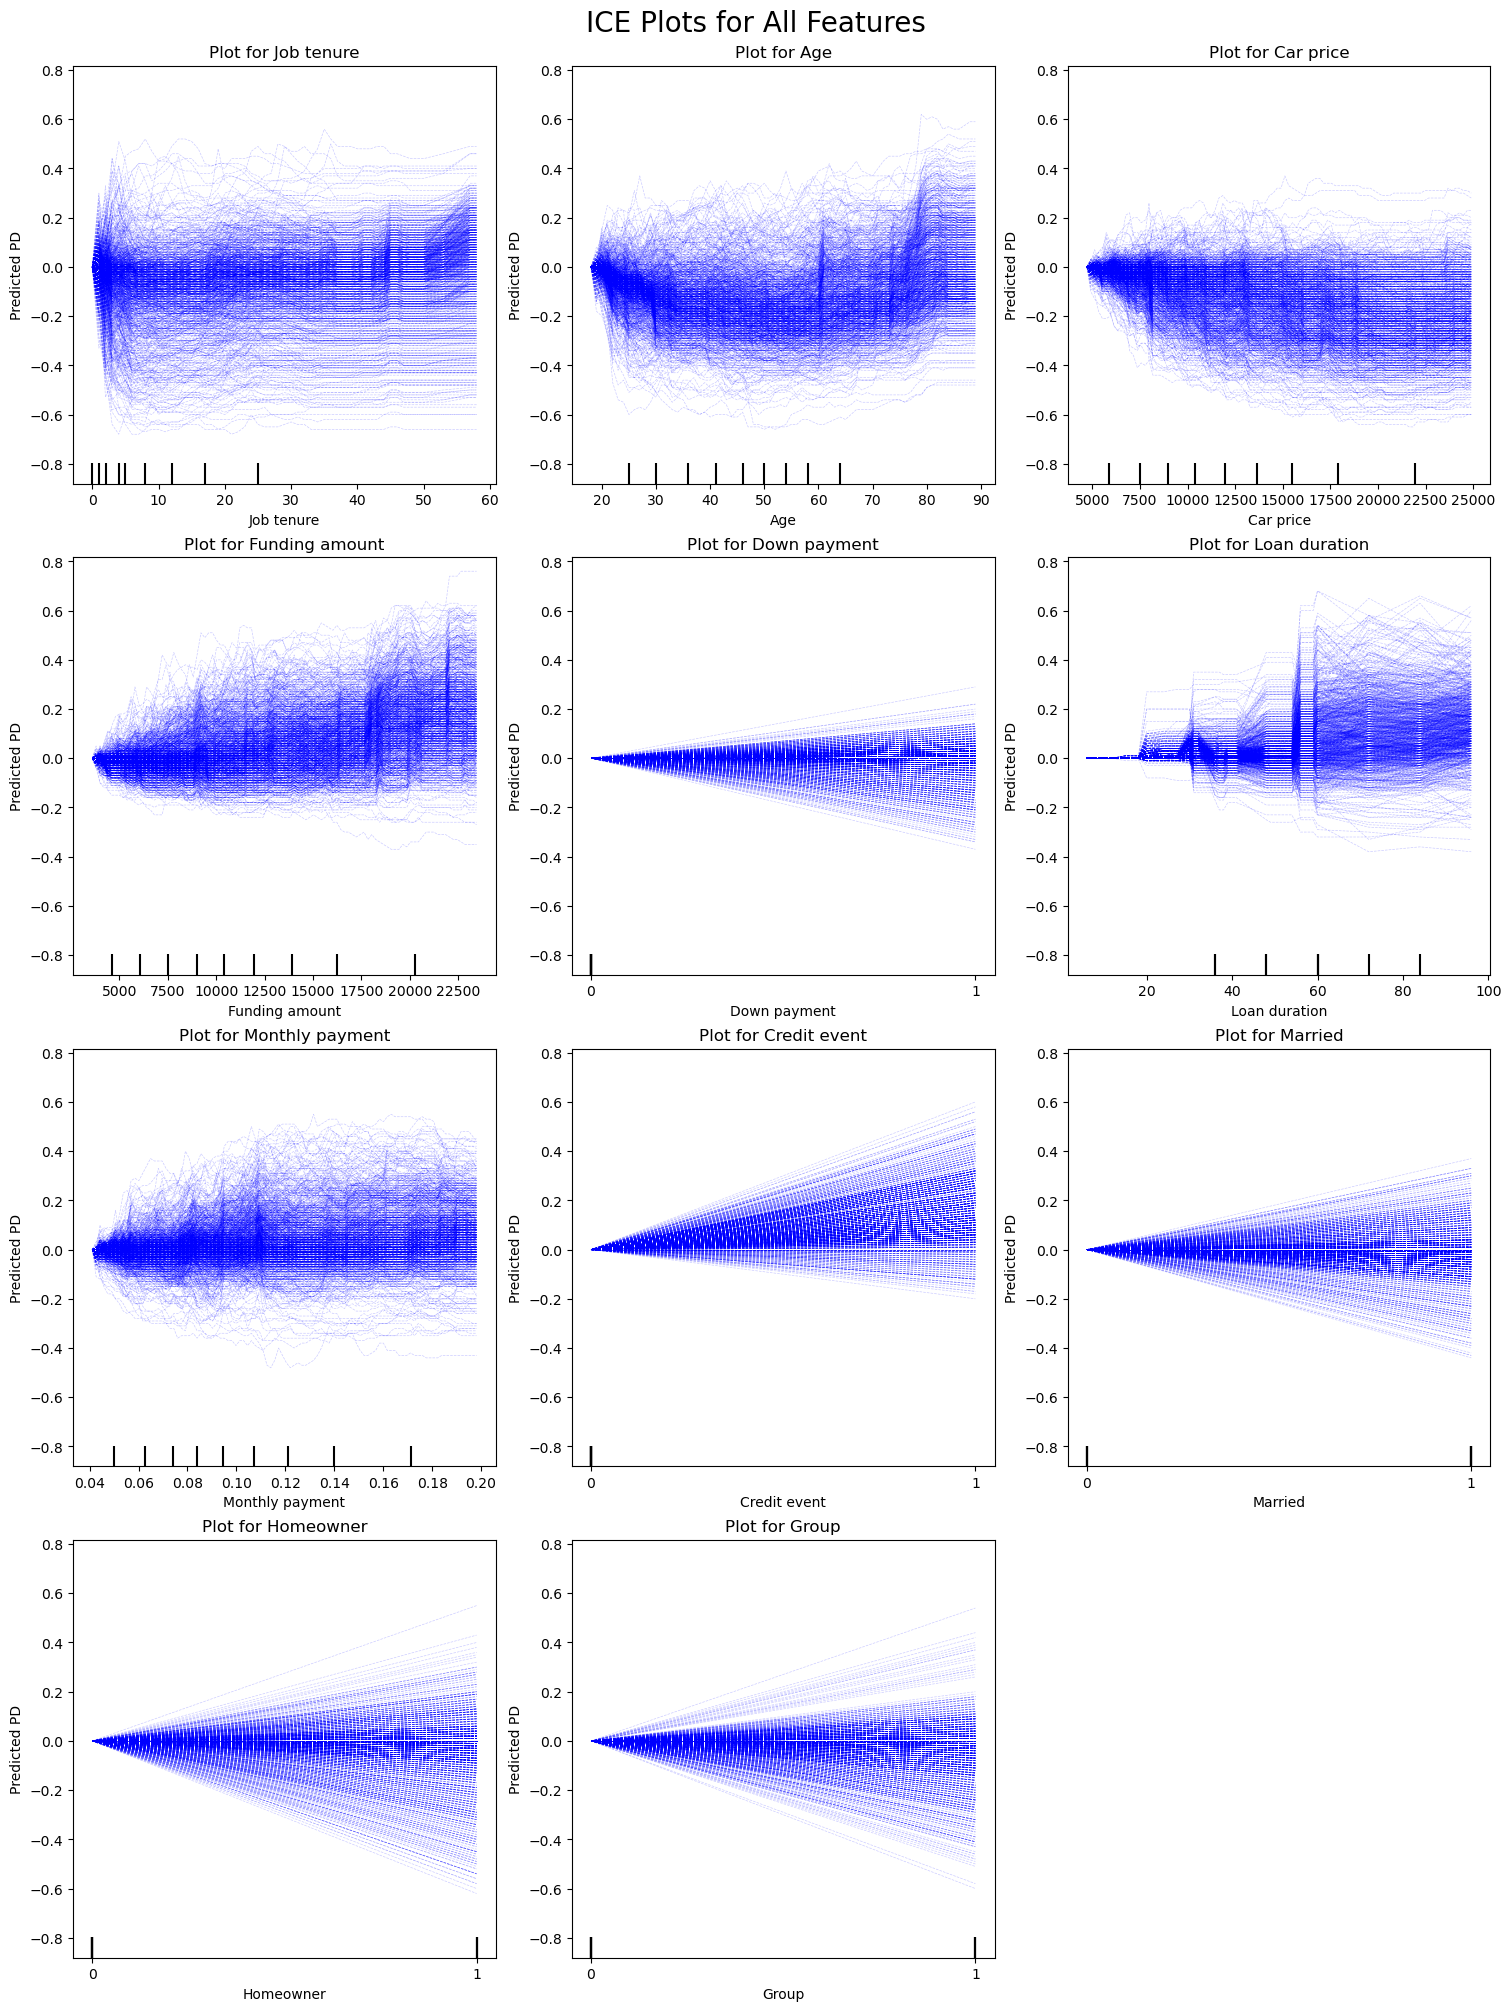

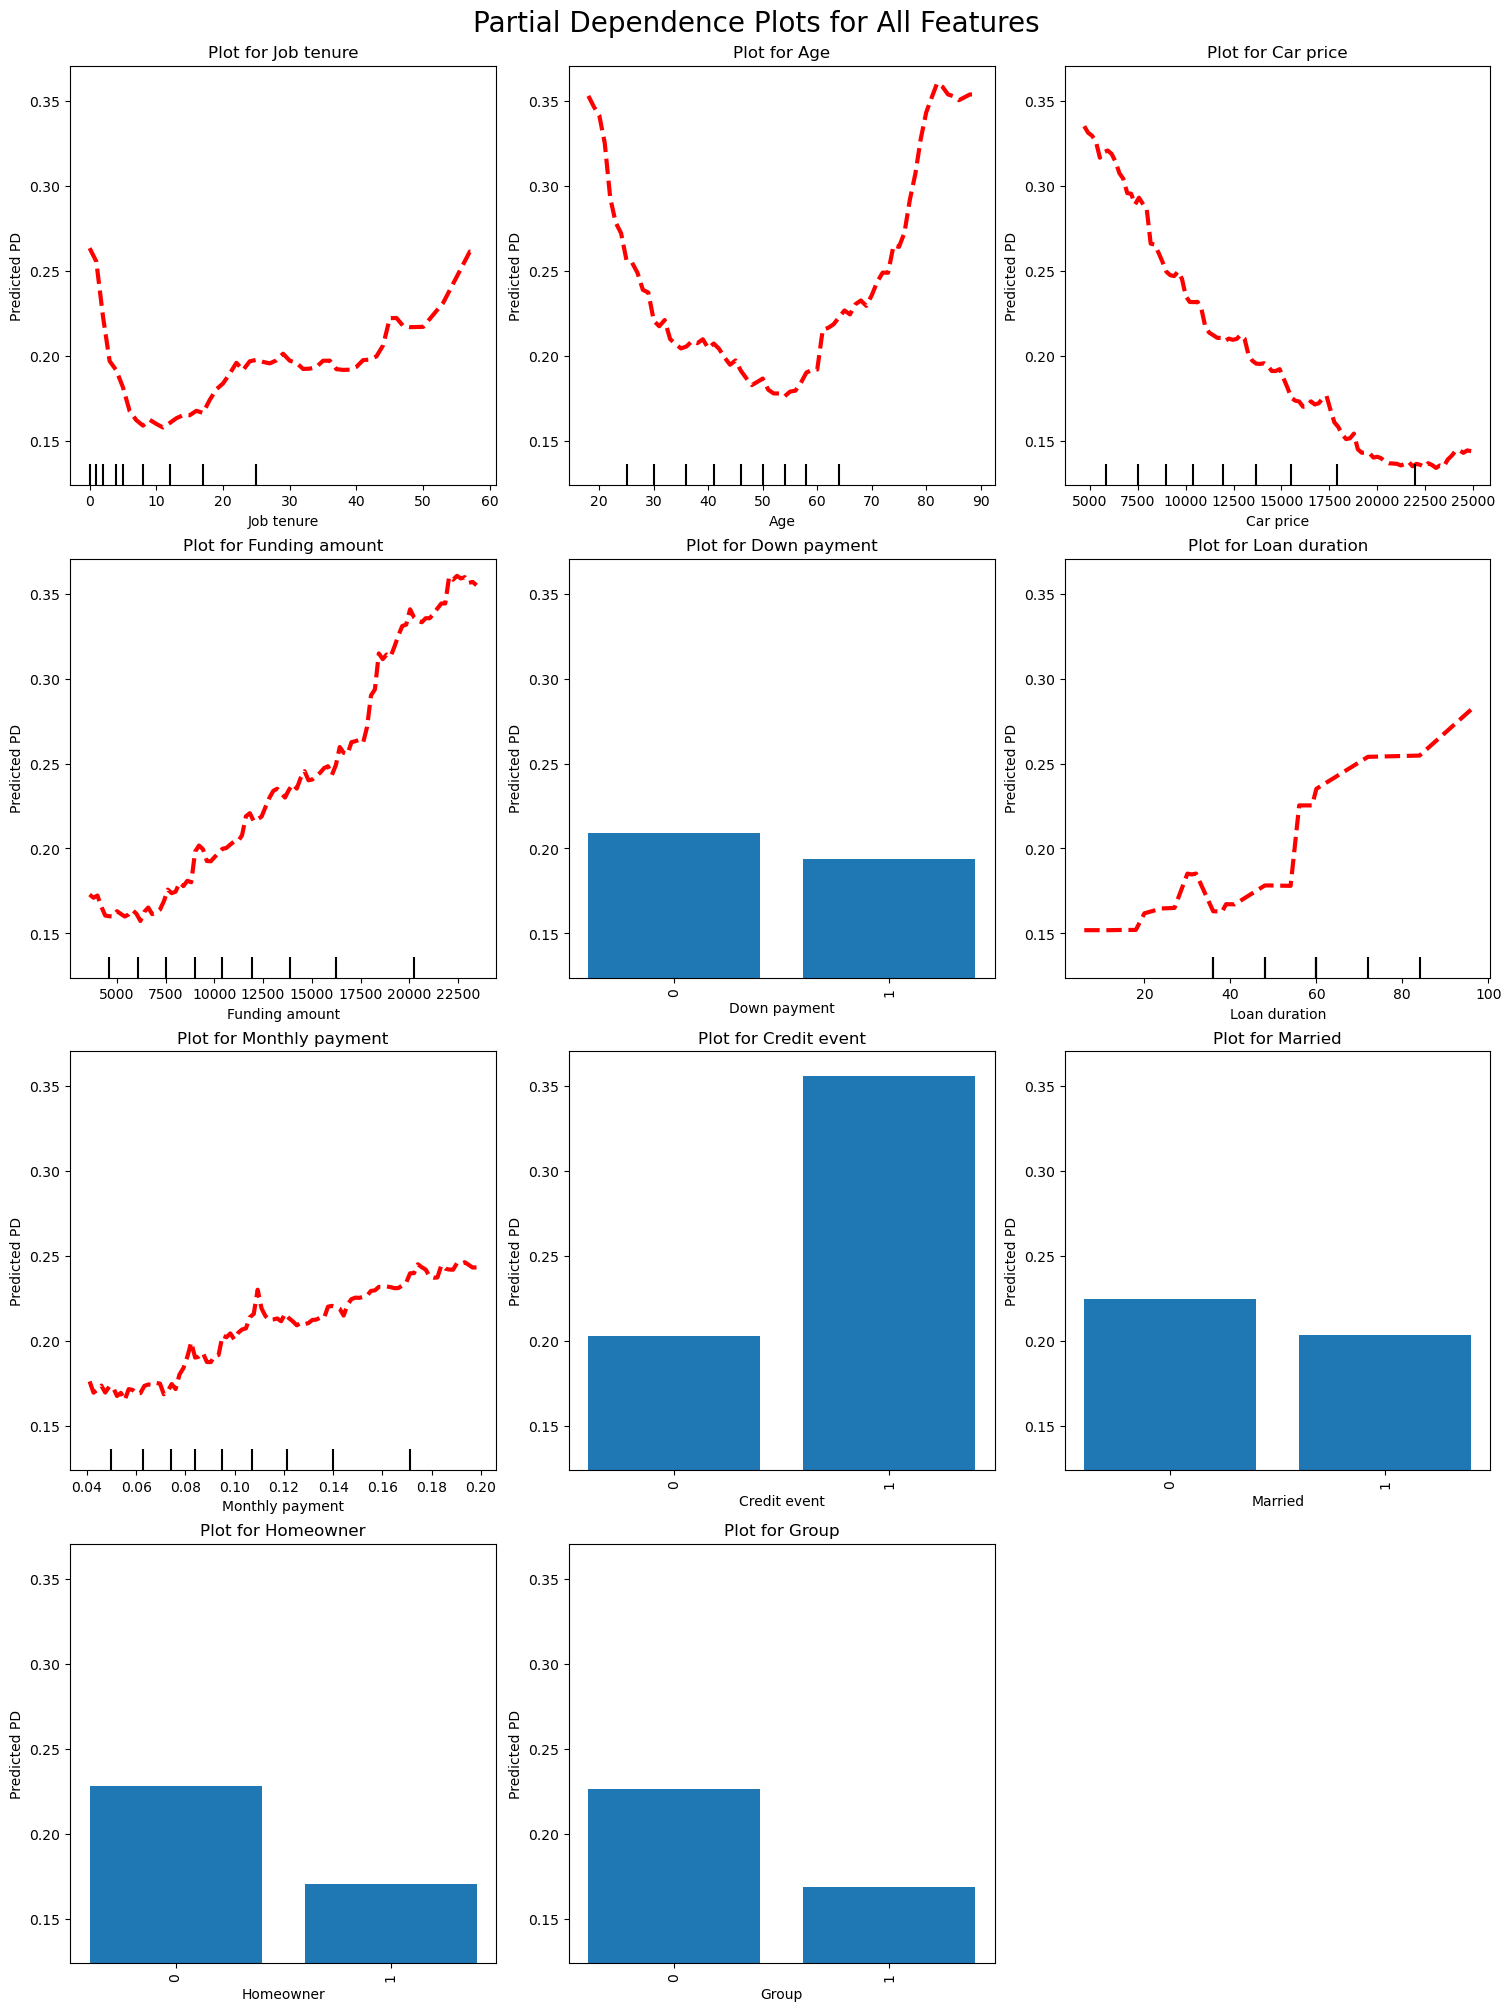

In [185]:
for k in ["both", "average"]:
    plot_partial_dependence(rf_model, X, kind=k)